In [3]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
from faker import Faker

In [4]:
fake = Faker()
names = [fake.name() for _ in range(50000)]



random_floats = np.random.uniform(0, 287557.9, 10000)

#Задаем начальную и конечную дату для генерации временных меток
start_d = datetime(2020, 1, 1)
end_d = datetime(2021, 1, 1)

# Генерация случайных дат
dat = np.random.randint(start_d.timestamp(), end_d.timestamp(), 1000000)

#Генерируем итоговый датасет
test_data = pd.DataFrame({'date':[datetime.fromtimestamp(date) for date in dat],
                        'numb':[random.choice(random_floats) for _ in range(1000000)],
                        'name':[random.choice(names) for _ in range(1000000)]})
#Сортируем данные по дате и переопределяем индекс
test_data.sort_values('date').reset_index(drop=True)
duplicates = test_data.sample(frac=0.1, replace=True)
test_data = pd.concat([test_data, duplicates], ignore_index=True)

In [5]:
#удалить пустые / na строки
#удалить дубли
#строки в которых нет цифр превратить в пустые
def remove_d(df):
    df.drop_duplicates(ignore_index=True, inplace=True)
    return df

def remove_empty(df):
    df.dropna()
    return df
    


#создаем новый датафрейм на основе основного, с средней, медианой и количеством уникальных значений на каждый час
def agg_df(df):
    short_d_ag = pd.DataFrame({
                           'h_mean': df.groupby(df['date'].dt.floor('h'))['numb'].mean().round(2),
                           'h_median': df.groupby(df['date'].dt.floor('h'))['numb'].median().round(2),
                           'unic': df.groupby(df['date'].dt.floor('h'))['name'].nunique()})
    
    return short_d_ag

#SQL запрос для агрегации данных, сгруппированных на каждый час
#SELECT date_trunc('hour', date) date
#       avg(numb) h_mean,
#       median(numb) h_median,
#       count(distinct name) unic
#FROM test_data
#group by date_trunc('hour', date)

#merge соединяем основной датафрейм и датафрейм с агрегированными данными
def merge_df(df1, df2):
    df1['hours'] = df1['date'].dt.floor('h')
    full_short_d = pd.merge(df1, df2, left_on = 'hours', right_on = 'date')
    return full_short_d

#Строим гистограмму для колонки чисел с плавающей точкой
def hist(df):
    plt.hist(df['numb'],color = 'blue', edgecolor = 'black')
    plt.title('Гистограмма')

#Строим график средней величины по месяцам для колонки с числами
def pl_avg_numb(df):
    
    vis = pd.DataFrame(df.groupby(df['date'].dt.to_period(freq='M').dt.to_timestamp())['numb'].mean())
    line = sns.lineplot(data=vis, x='date', y='numb')
    line.set_title('Среднее значение numeric по месяцам')
    line.set_xlabel(None)
    line.set_ylabel(None)


#Строим тепловую карту для частотности символом в колонке с именами,
#для этого ощищаем имена от пробелом и других ненужных символов,
#агрегируем по месяцам
def heatmap(df):


    df_grouped = df.groupby(df['date'].dt.to_period(freq='M').dt.to_timestamp())['name'].apply(' '.join).reset_index()
    df_grouped['name'] = [''.join(filter(str.isalpha, string.lower())) for string in df_grouped['name']]

    df_grouped = pd.concat([df_grouped, df_grouped['name'].apply(lambda x: pd.Series({c: x.count(c) for c in set(x)}))], axis=1)
    df_grouped = df_grouped.drop(columns=['name'])
    df_grouped['date'] = pd.to_datetime(df_grouped['date']).dt.to_period('M')
    df_grouped.set_index('date', inplace=True) 
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(df_grouped, cbar_kws= {'orientation': 'horizontal'} )
    heatmap.set_title('Тепловая карта по датам и частоте символов')
    heatmap.set_ylabel(None)


Очищаем данные от пропуска значений и удаляем дубликаты

In [6]:

test_data = remove_d(test_data)
test_data = remove_empty(test_data)
print(test_data)

                      date           numb                name
0      2020-01-01 00:22:03   75712.917816      Nathan Freeman
1      2020-05-02 21:25:37  253303.087101       Joseph Miller
2      2020-08-26 09:08:30  265926.520573     Steven Hamilton
3      2020-08-06 07:10:45  113438.535375            Zoe Bond
4      2020-04-09 03:24:42   10271.565602       Regina Snyder
...                    ...            ...                 ...
999995 2020-05-02 21:20:31   45654.720995       Jose Stephens
999996 2020-09-10 23:19:37  224710.806604       Casey Roberts
999997 2020-05-11 12:50:52  286595.339838  Catherine Fletcher
999998 2020-03-19 17:12:07  107924.861043       Bradley Moore
999999 2020-07-13 01:04:24  200219.392245    Jacob Fowler Jr.

[1000000 rows x 3 columns]


Агрегируем данные на каждый час и соединяем данные с основной таблицей

In [59]:
test_data = merge_df(test_data, agg_df(test_data))
test_data.drop('hours', axis=1, inplace=True) #удаляем вспомогательную колонку
print(test_data)

                      date           numb               name     h_mean  \
0      2020-06-14 13:59:55   83268.555906     Ashley Goodman  162557.31   
1      2020-12-01 20:54:25  214253.237936    Patricia Martin  150102.53   
2      2020-02-05 22:42:48  110467.996992    Thomas Robinson  137636.49   
3      2020-11-15 16:16:25   47136.074031        Travis Dyer  145861.86   
4      2020-07-30 03:56:06   98948.379456       Brenda Brown  154501.56   
...                    ...            ...                ...        ...   
999995 2020-05-07 21:37:13   61022.306591      Christie Luna  143558.51   
999996 2020-04-05 12:21:46  142496.179826     Ashley Calhoun  136159.99   
999997 2020-07-10 21:41:27  120320.393950          Susan Orr  139728.72   
999998 2020-03-12 09:39:20  110193.603185     Steven Johnson  148720.54   
999999 2020-06-20 16:17:22   22761.501992  Jennifer Thompson  143066.64   

         h_median  unic  
0       161830.77   118  
1       155380.34   109  
2       140421.79   1

Строим гистограмму по значениям в колонке с числами

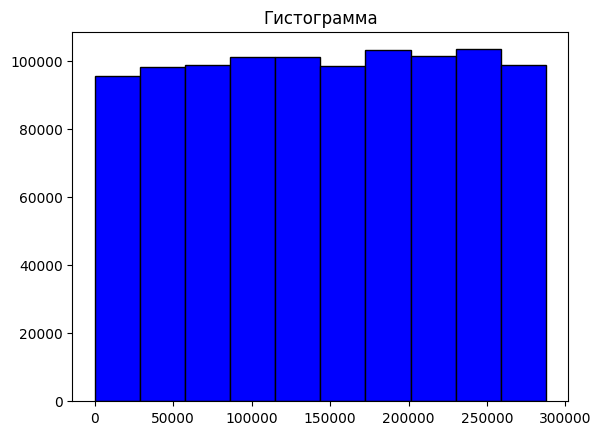

In [60]:
hist(test_data)

График показывающий среднее значение в колонке с числом по месяцам

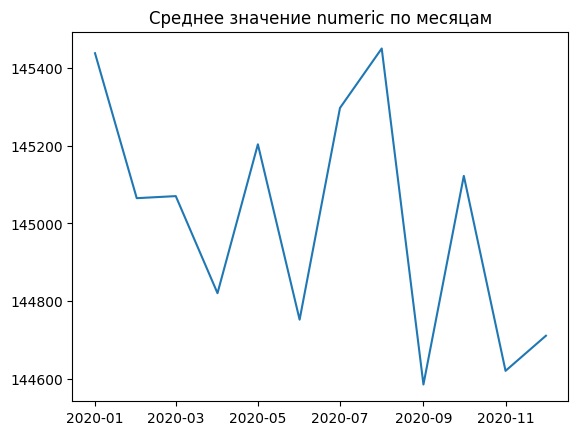

In [61]:
pl_avg_numb(test_data)

Тепловая карта для частотности символов сгруппированная по месяцам

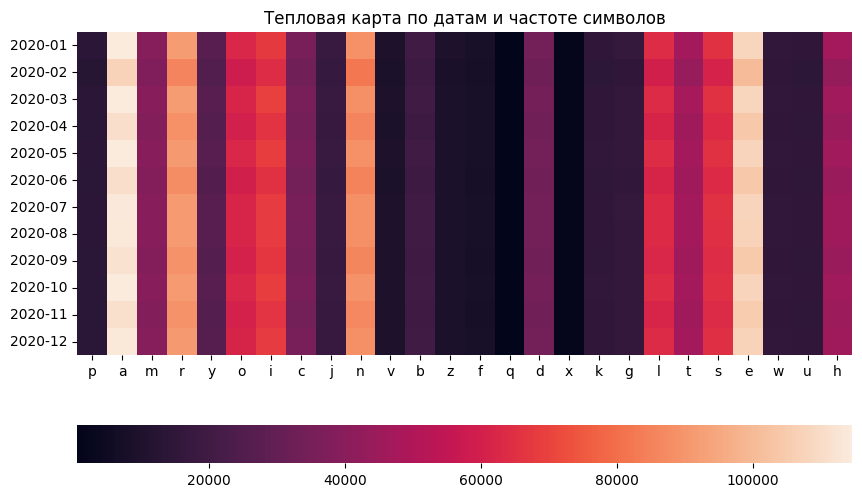

In [62]:
heatmap(test_data)